# Daily + weekly seasonality model

Modelling both daily and weekly seasonality with gaussian process on $log(lambda)$

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl
import numpy as np
import scipy

import pymc as pm
import arviz as az

import warnings

sns.set(rc={'figure.figsize':(17,11)})

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pl.read_parquet("../data/counter_data.parquet").with_columns(pl.col("weekday") - 1)

In [3]:
data.select(pl.col("site_name").unique()).to_numpy()

array([['Thorndon Quay'],
       ['Basin Reserve'],
       ['Oriental Road'],
       ['Brooklyn Road - up hill'],
       ['Salamanca Road'],
       ['Hutt Road Cycle Sign Virtual'],
       ['Mt Vic Tunnel'],
       ['Crawford'],
       ['Evans Bay Shared Path'],
       ['Evans Bay'],
       ['Airport Tunnel Counter'],
       ['Oriental Parade Shared Path'],
       ['Cobham Drive Shared Path'],
       ['Tawa Shared Path (Southern end)'],
       ['Adelaide Road'],
       ['Tawa Shared Path (At Kenepuru)'],
       ['Oriental Cycle Sign Virtual 2 Bins'],
       ['Hutt Road Shared Path'],
       ['Tasman Street'],
       ['Glenmore Street'],
       ['Willis St'],
       ['Willowbank'],
       ['Burma Road']], dtype=object)

In [4]:
temp_data = pl.read_parquet("../data/weather_temp.parquet")
wind_data = pl.read_parquet("../data/weather_wind.parquet")
rain_data = pl.read_parquet("../data/weather_rain.parquet")

In [5]:
temp_data

record_time,temp_max_c,temp_min_c,temp_avg_c,rel_humidity_perc,year,month,day,hour
datetime[μs],f64,f64,f64,i64,i32,u32,u32,u32
2018-01-01 00:00:00,18.6,18.3,18.4,83,2018,1,1,0
2018-01-01 01:00:00,18.6,18.4,18.5,83,2018,1,1,1
2018-01-01 02:00:00,18.6,18.3,18.4,84,2018,1,1,2
2018-01-01 03:00:00,18.5,18.2,18.3,83,2018,1,1,3
2018-01-01 04:00:00,18.3,18.1,18.2,83,2018,1,1,4
2018-01-01 05:00:00,18.3,15.5,17.4,84,2018,1,1,5
2018-01-01 06:00:00,15.6,15.1,15.3,88,2018,1,1,6
2018-01-01 07:00:00,15.2,14.9,14.9,91,2018,1,1,7
2018-01-01 08:00:00,15.6,15.0,15.2,90,2018,1,1,8


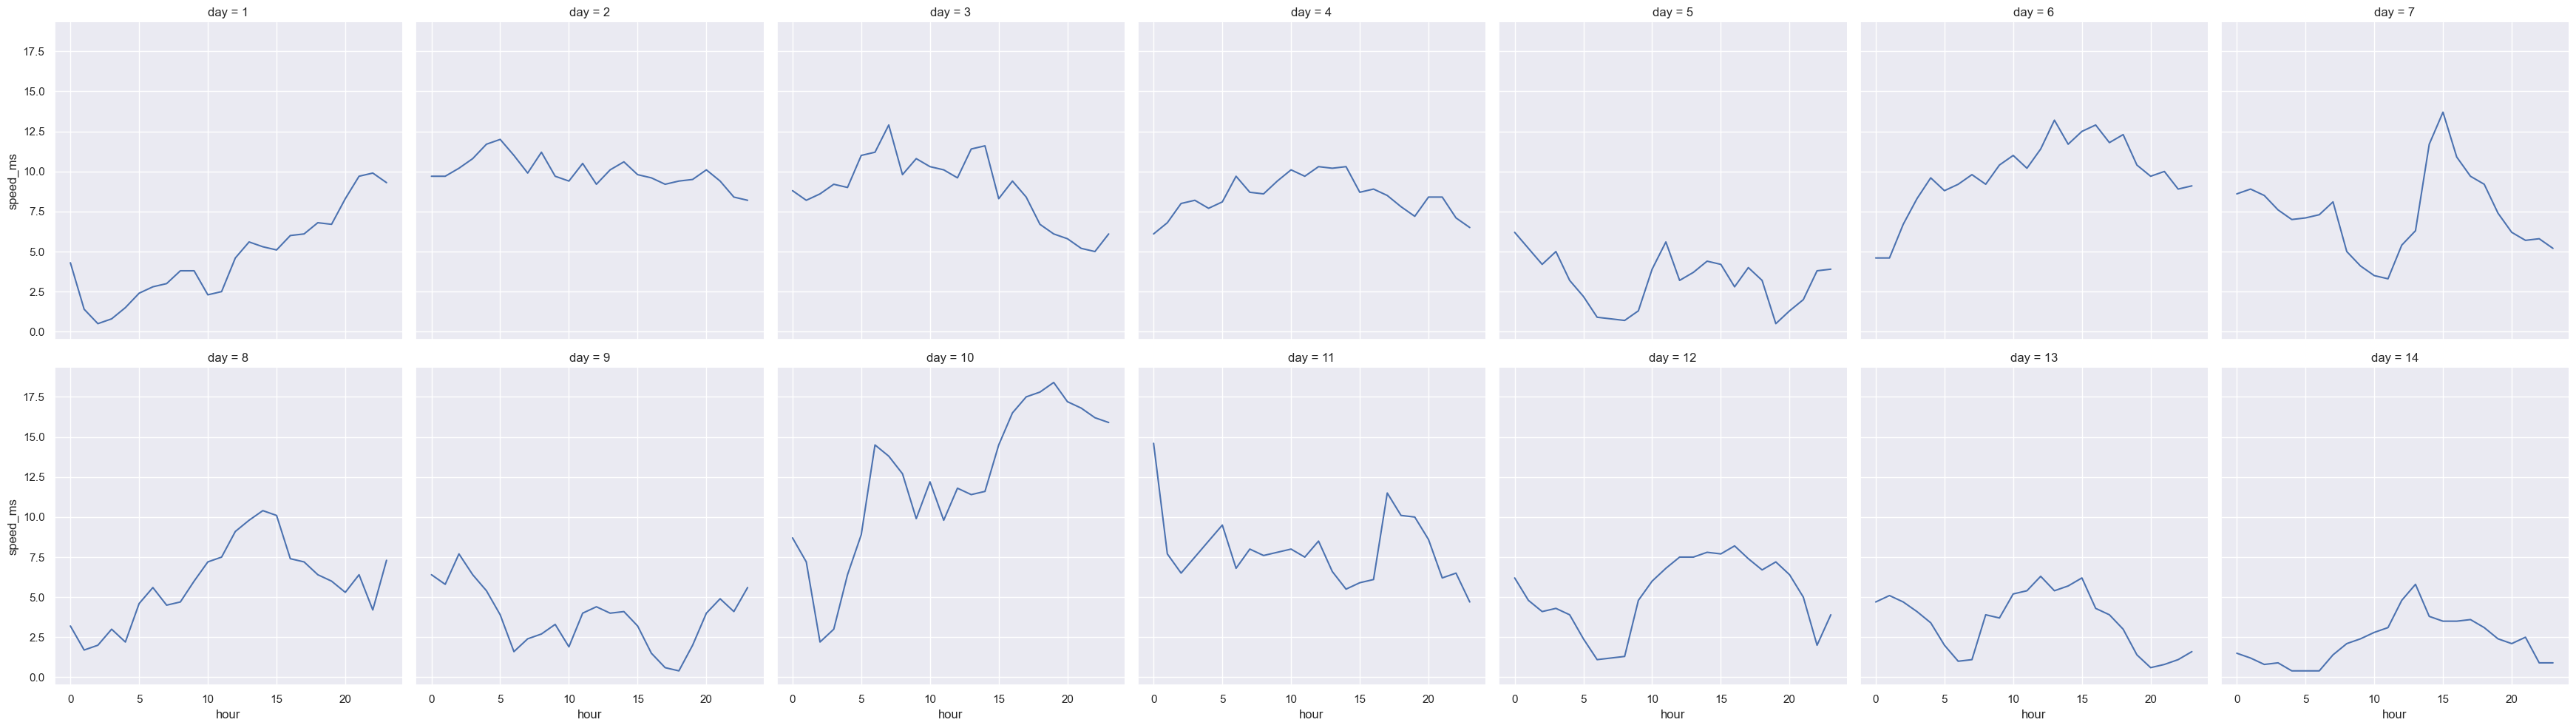

In [6]:
sns.relplot(
    wind_data.filter((pl.col("year") == 2018) & (pl.col("month") == 4) & (pl.col("day") <= 14)),
    x="hour",
    y="speed_ms",
    col="day",
    col_wrap=7,
    kind="line"
)

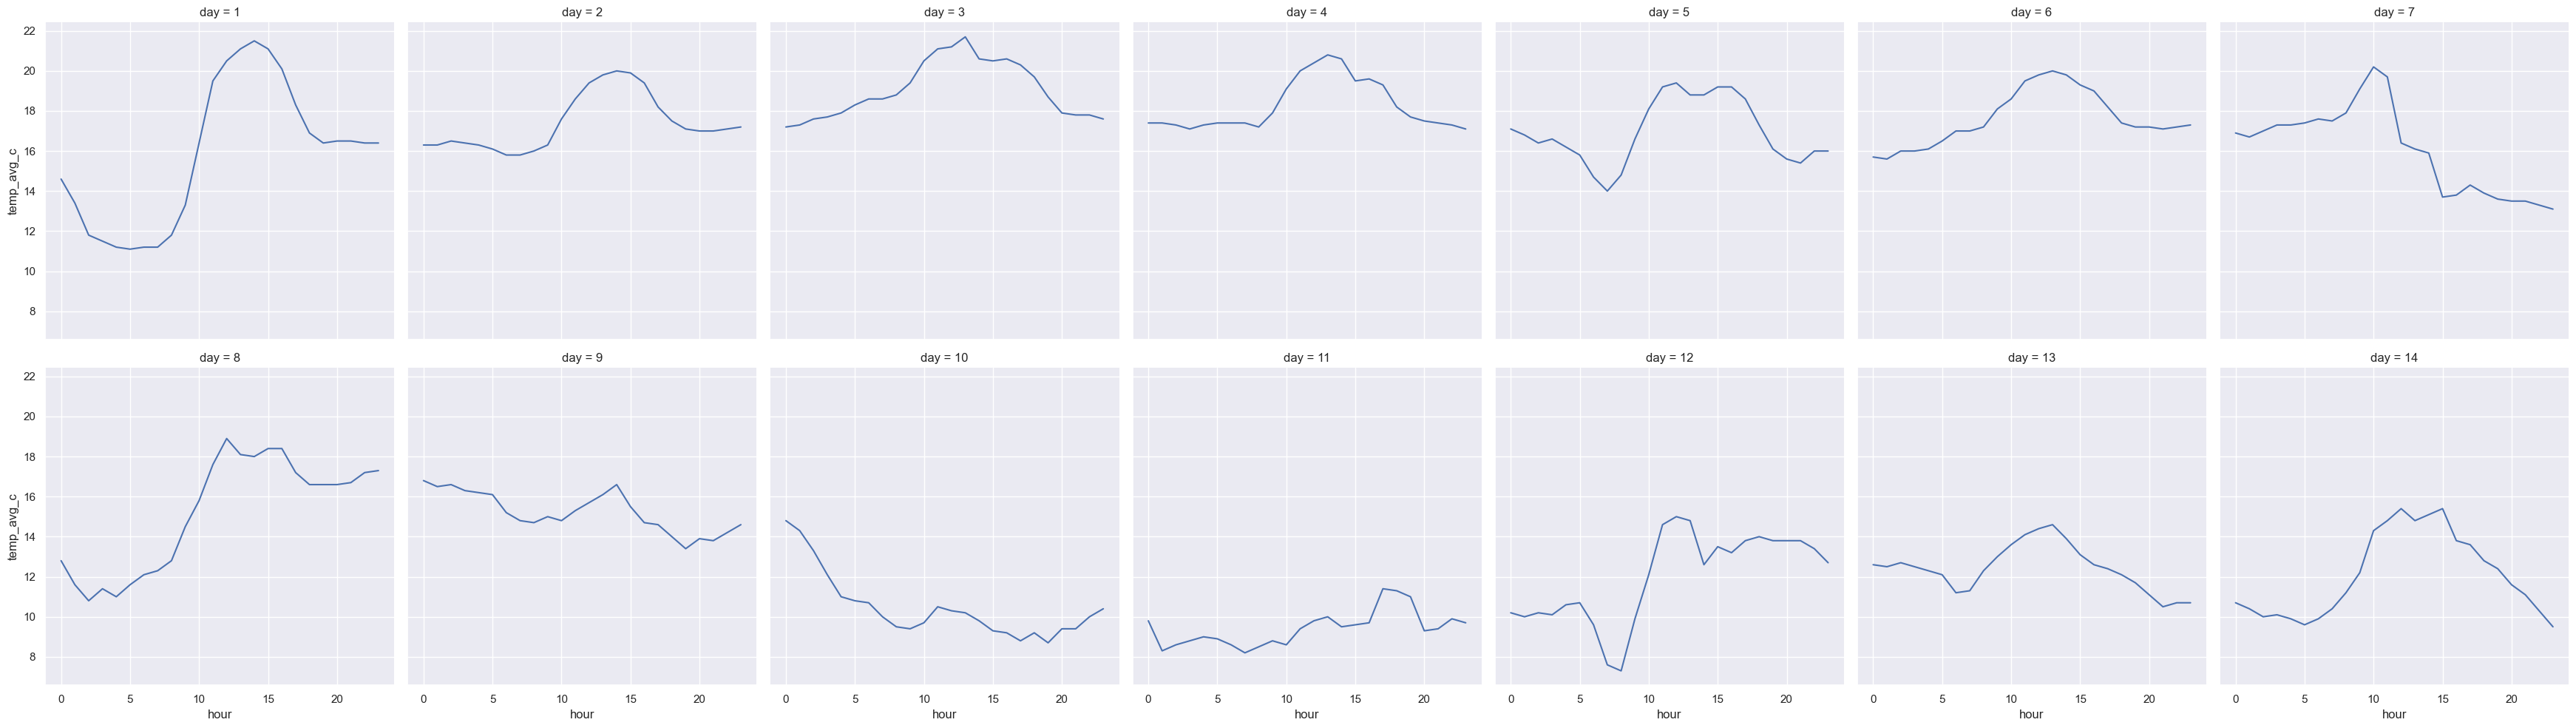

In [7]:
sns.relplot(
    temp_data.filter((pl.col("year") == 2018) & (pl.col("month") == 4) & (pl.col("day") <= 14)),
    x="hour",
    y="temp_avg_c",
    col="day",
    col_wrap=7,
    kind="line"
)

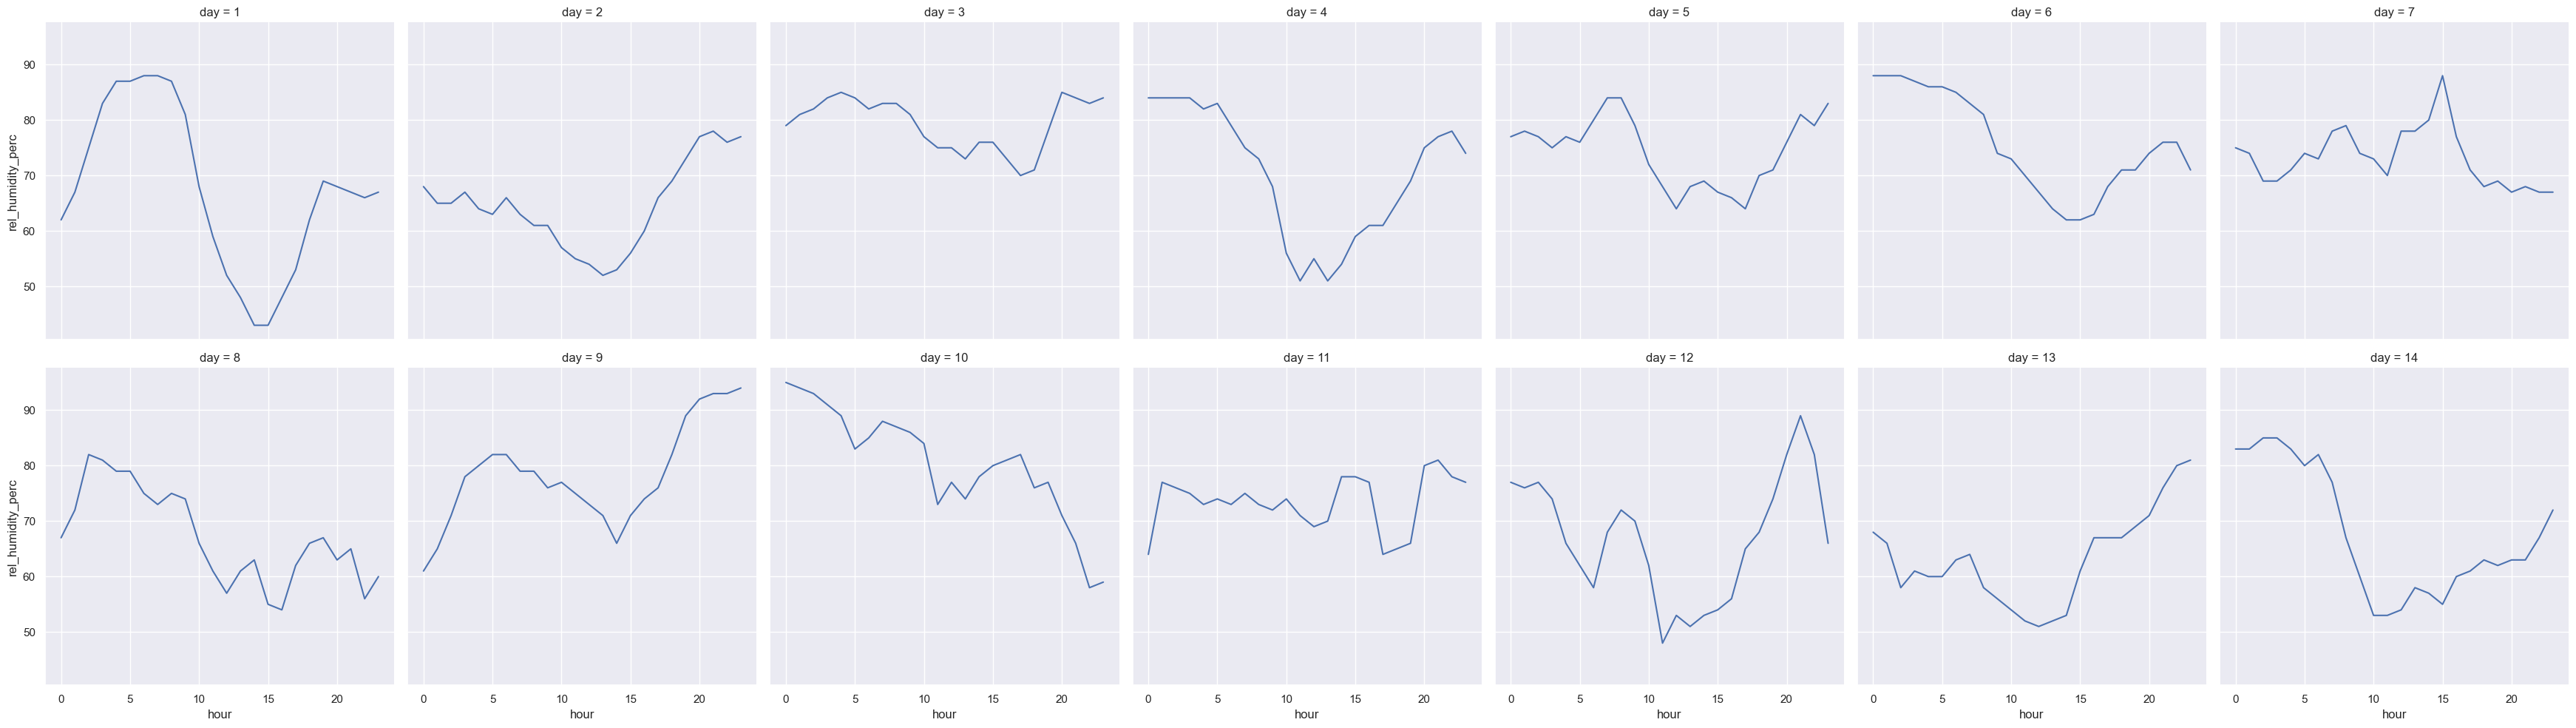

In [8]:
sns.relplot(
    temp_data.filter((pl.col("year") == 2018) & (pl.col("month") == 4) & (pl.col("day") <= 14)),
    x="hour",
    y="rel_humidity_perc",
    col="day",
    col_wrap=7,
    kind="line"
)

In [9]:
wind_data.filter(pl.col("speed_ms").is_null())

record_time,dir_deg,speed_ms,dir_std,speed_std,period,year,month,day,hour
datetime[μs],i64,f64,f64,f64,f64,i32,u32,u32,u32


In [10]:
filtered_data = data.filter(
    (pl.col("year") == 2022) &
    (pl.col("site_name") == "Thorndon Quay")
).with_columns(
    pl.col("count_outgoing").fill_null(0)
).join(
    temp_data,
    on=[pl.col("year"), pl.col("month"), pl.col("day"), pl.col("hour")],
    how="left"
).drop(
    "record_time_right"
).join(
    wind_data,
    on=[pl.col("year"), pl.col("month"), pl.col("day"), pl.col("hour")],
    how="left",
).drop(
    "record_time_right"
).with_columns(
    pl.col("temp_avg_c").fill_null(pl.col("temp_min_c"))
).with_columns(
    pl.col("temp_avg_c").fill_null(strategy="forward"),
    pl.col("speed_ms").fill_null(strategy="mean"),
    pl.col("rel_humidity_perc").fill_null(strategy="mean")
).with_columns(
    ((pl.col("temp_avg_c") - pl.col("temp_avg_c").mean()) / pl.col("temp_avg_c").std()).cast(float).alias("temp_z"),
    ((pl.col("rel_humidity_perc") - pl.col("rel_humidity_perc").mean()) / pl.col("rel_humidity_perc").std()).cast(float).alias("humidity_z"),
    ((pl.col("speed_ms") - pl.col("speed_ms").mean()) / pl.col("speed_ms").std()).cast(float).alias("windspeed_z")
)

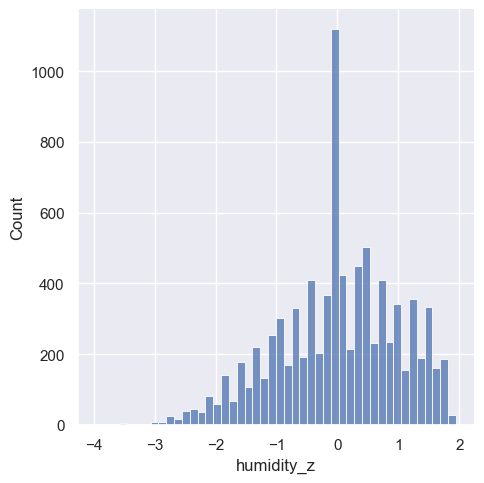

In [11]:
sns.displot(filtered_data, x="humidity_z")

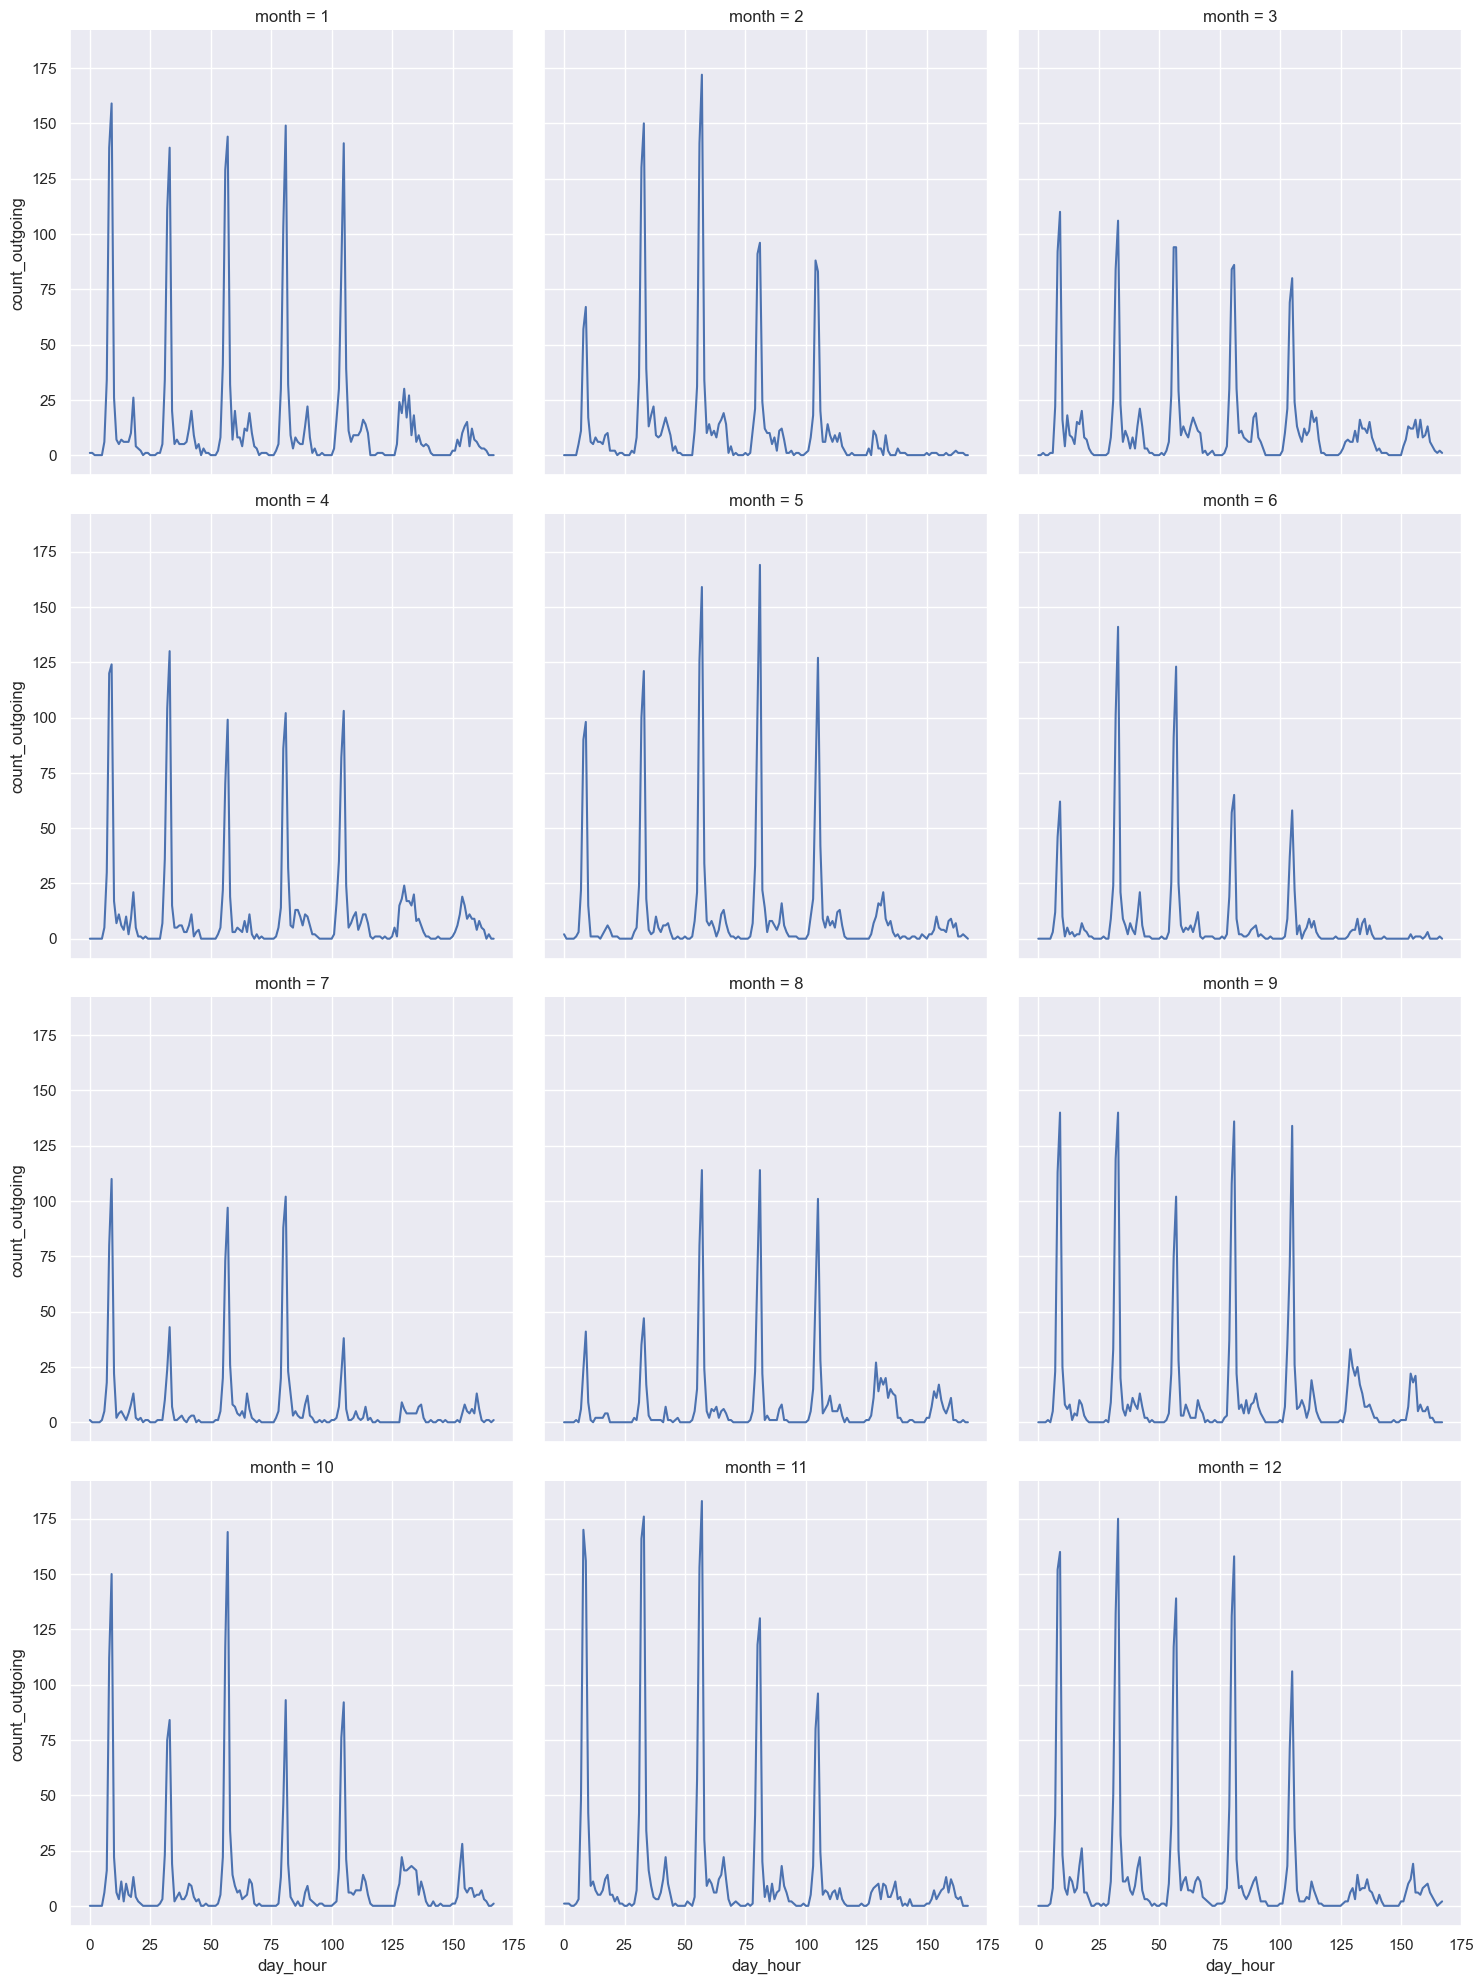

In [12]:
sns.relplot(
    (
        filtered_data.filter(
            (pl.col("day") > 7) & (pl.col("day") <= 14)
        ).with_columns(
            (pl.col("weekday") * 24 + pl.col("hour")).alias("day_hour")
        )
    ),
    x="day_hour", 
    y="count_outgoing",
    kind="line",
    col="month",
    col_wrap=3,
)

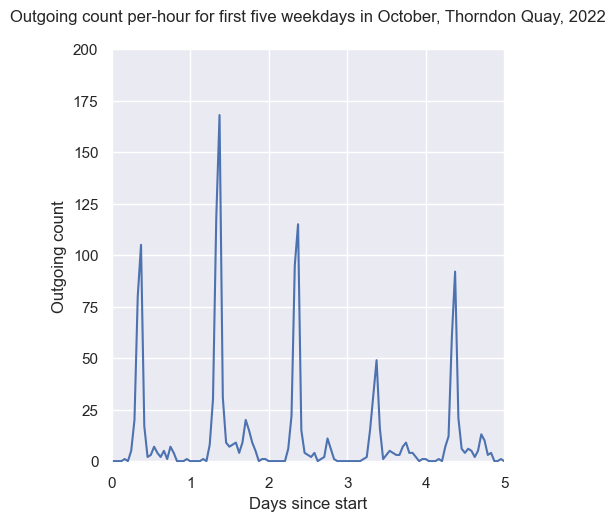

In [13]:
sns.relplot(
    (
        filtered_data.filter(
            (pl.col("month") == 10) &
            (pl.col("day") <= 7)
        )
        .with_columns(
            (pl.col("weekday") * 24 + pl.col("hour")).alias("day_hour")
        )
    ), 
    x="day_hour", 
    y="count_outgoing",
    kind="line"
)
plt.xlabel("Days since start")
plt.ylabel("Outgoing count")
plt.ylim(-1,200)
plt.xlim(0,24*5)
plt.xticks([24*i for i in range(6)], list(range(6)))
plt.title("Outgoing count per-hour for first five weekdays in October, Thorndon Quay, 2022", pad=20);

Model describes bike count $c_i$ as GammaPoisson distribution conditional on time of day, for data sampled where: 

- location = "Thorndon Quay"
- year = 2022
- day = {monday, tuesday, wednesday, thursday, friday}
- direction = "Outgoing"

$hour[i]$ is indexed hour of day for sample $i$, with "12am-1am" = 0. 

\begin{align}
c_i &\sim GammaPoisson(\phi, \mu_i) \\
\log{(\mu_i)} &= \lambda_{hour[i]} \\
\lambda_{j = 0..23} &\sim MVNormal([0,0,\dots,0]^T, K) \\
K &= Periodic(24, \tau) \\
\phi &\sim Exponential(1) \\
\tau &\sim Exponential(0.1)
\end{align}

In [14]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

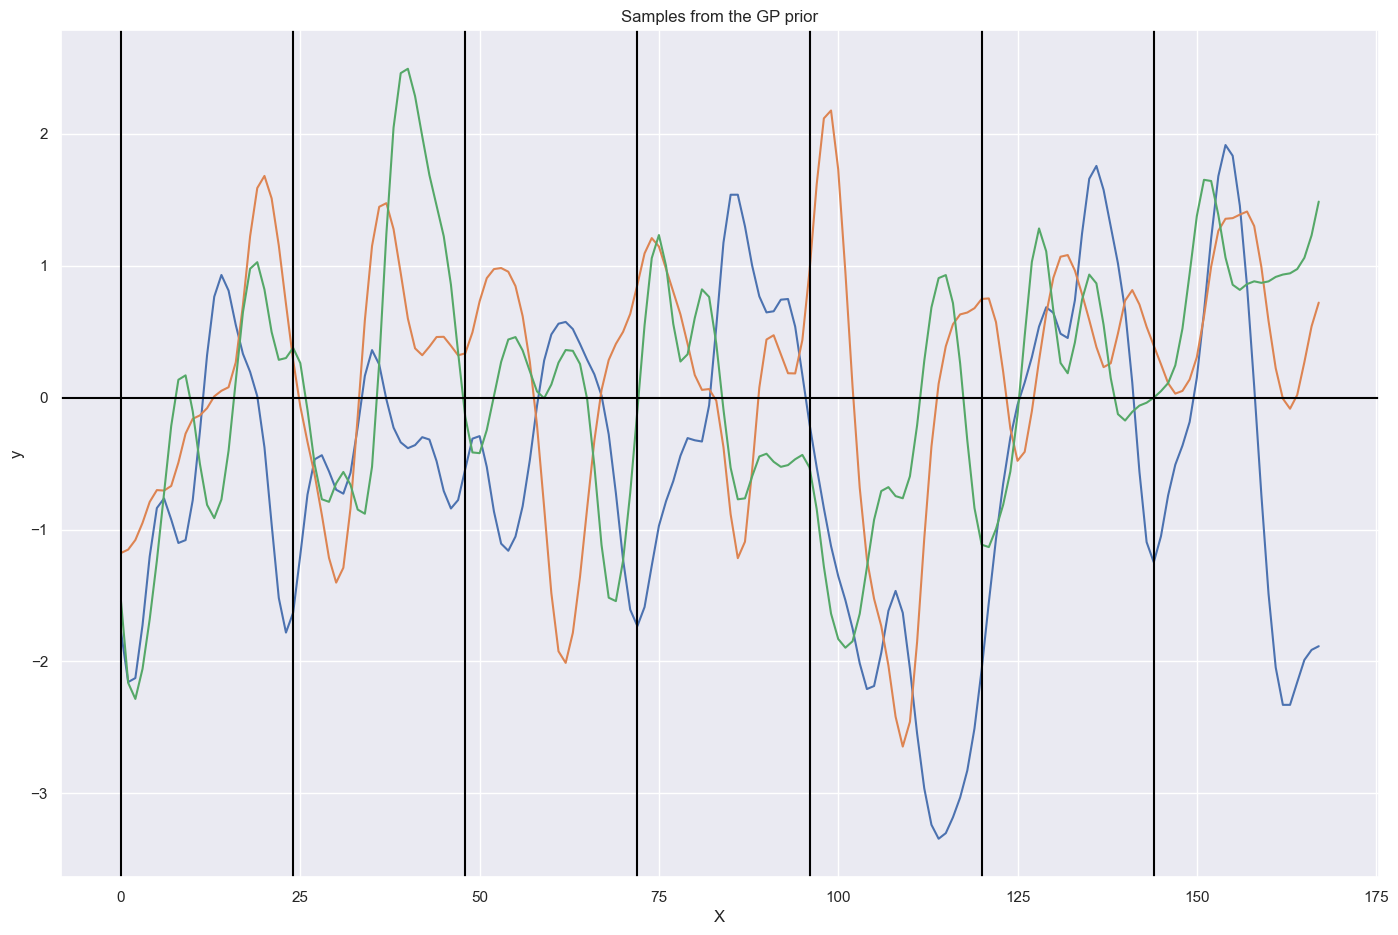

In [15]:
X = np.arange(24*7)[:, None]
# X = np.arange(24*3)[:, None]

period = [24, 24*7]
ls = [0.5, 24]
cov1 = pm.gp.cov.Periodic(1, period=period[0], ls=ls[0])
cov2 = pm.gp.cov.ExpQuad(1, 6)
cov3 = pm.gp.cov.Periodic(1, period=period[1], ls=ls[1])
cov = cov1 * cov2 * cov3
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

K = cov(X).eval()
plt.plot(
    X,
    pm.draw(pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=len(K)), draws=3, random_seed=rng).T,
)
for p in np.arange(0, 24*7, 24):
    plt.axvline(p, color="black")
plt.axhline(0, color="black")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [18]:
with pm.Model() as m_3:
    hour = pm.MutableData("hour", np.array(filtered_data["hour"]), dims="obs_id")
    weekday = pm.MutableData("weekday", np.array(filtered_data["weekday"]), dims="obs_id")
    temperature = pm.MutableData("temperature", np.array(filtered_data["temp_z"]), dims="obs_id")
    windspeed = pm.MutableData("windspeed", np.array(filtered_data["windspeed_z"]), dims="obs_id")
    humidity = pm.MutableData("humidity", np.array(filtered_data["humidity_z"]), dims="obs_id")
    
    # ls = pm.Exponential("ls", scale=[0.15, 5, 8])
    ls = pm.Exponential("ls", scale=[2, 1, 24])
    
    # hourly periodic effect
    cov_daily = pm.gp.cov.Periodic(1, period=24, ls=ls[0])
    
    # allowing variability to 24-hour period
    cov_daily *= pm.gp.cov.ExpQuad(1, ls=ls[1])
    
    # weekly periodic effect
    cov_weekly = pm.gp.cov.Periodic(1, period=24*7, ls=ls[2])
    
    # altogether
    cov = cov_daily * cov_weekly + pm.gp.cov.WhiteNoise(1e-4)
    
    # sample hourly * daily alphas
    K = cov(np.arange(24 * 7)[:, None]).eval()
    # alpha_raw = pm.MvNormal("alpha_raw", 0, 1, size=len(K))
    mu = pm.Normal("mu", 0, 1, shape=len(K))
    alpha = pm.MvNormal("alpha", mu=mu, cov=K, shape=len(K))
    
    beta = pm.Normal("beta", 0, 1, shape=3)
    
    # exponentiate to get lambda
    lmda = np.exp(
        alpha[weekday * 24 + hour]
        # beta[0] * temperature + 
        # beta[1] * windspeed +
        # beta[2] * humidity
    )
    # lmda = pm.Deterministic("lmda", np.exp(alpha + beta * temperature))
    
    # sample from Gamma Poisson
    phi = pm.Exponential("phi", scale=3)
    c = pm.NegativeBinomial("c", alpha=phi, mu=lmda, observed=np.array(filtered_data["count_outgoing"]), dims="obs_id")
    
    m_3.debug(verbose=True)
    # trace = pm.sample_prior_predictive(1000)
    trace = pm.sample(10000, tune=10000)
    trace.extend(pm.sample_posterior_predictive(trace))
    

point={'ls_log__': array([0.69314718, 0.        , 3.17805383]), 'mu': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'alpha': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls, mu, alpha, beta, phi]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 258 seconds.
Sampling: [c]


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

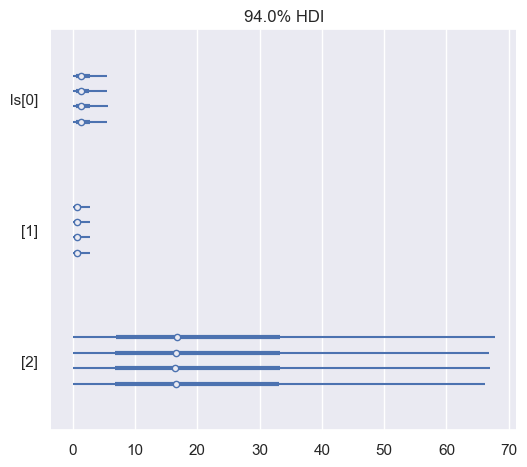

In [19]:
az.plot_forest(trace, var_names=["ls"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

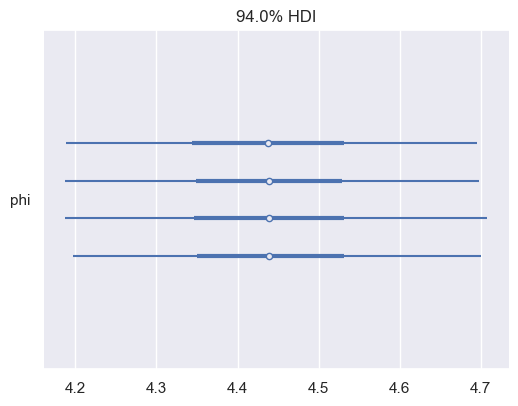

In [20]:
az.plot_forest(trace, var_names=["phi"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

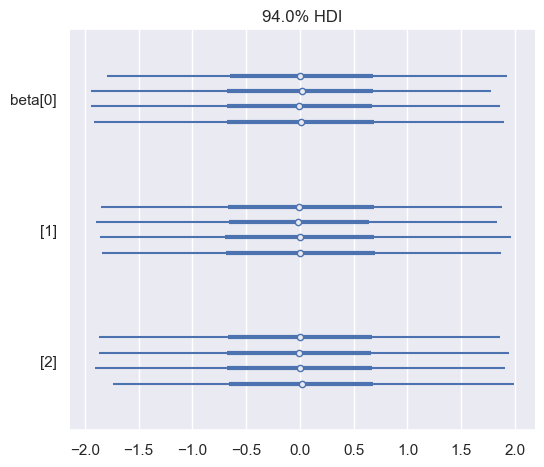

In [21]:
az.plot_forest(trace, var_names=["beta"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

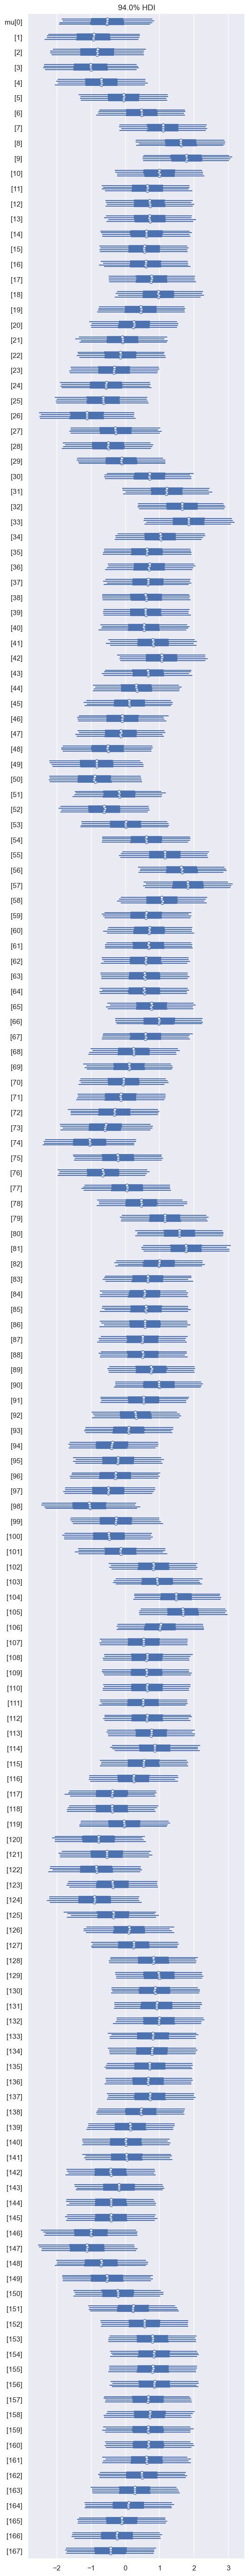

In [22]:
az.plot_forest(trace, var_names=["mu"])

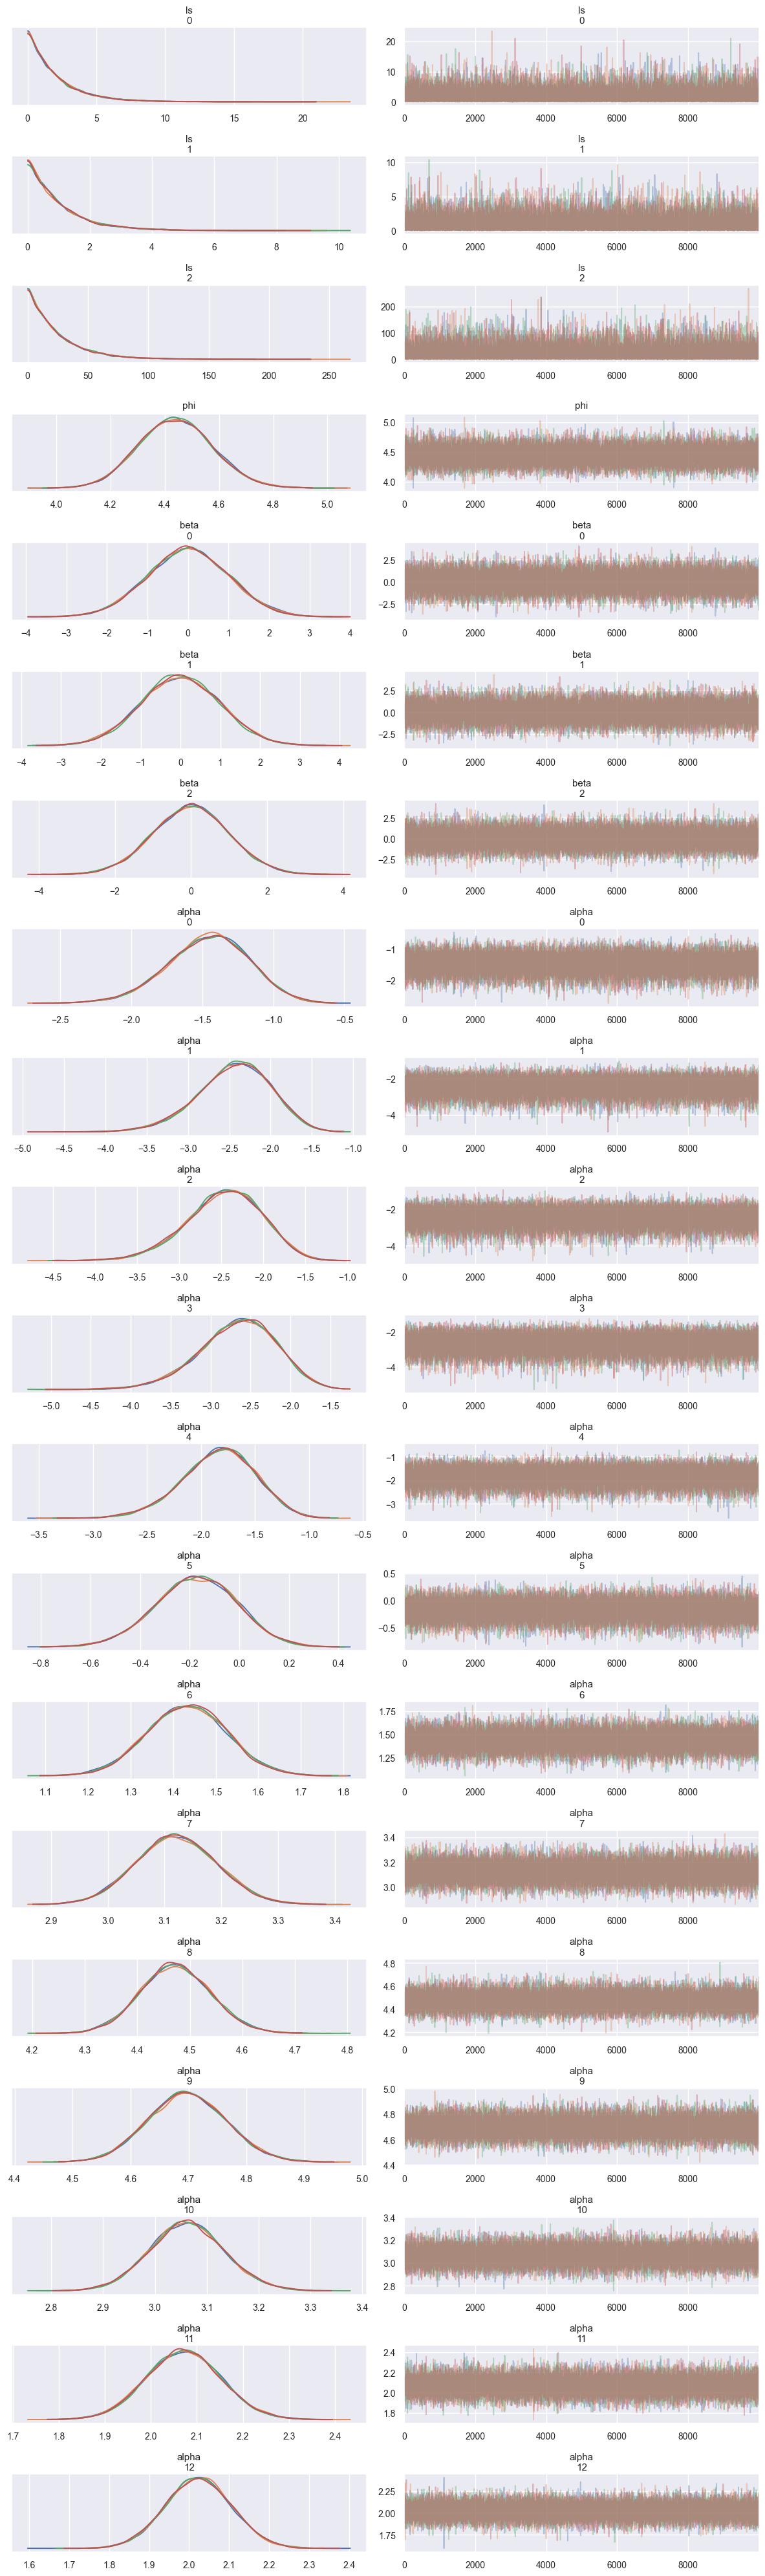

In [23]:
az.plot_trace(trace, compact=False, var_names=["ls", "phi", "beta", "alpha"]);
plt.tight_layout()

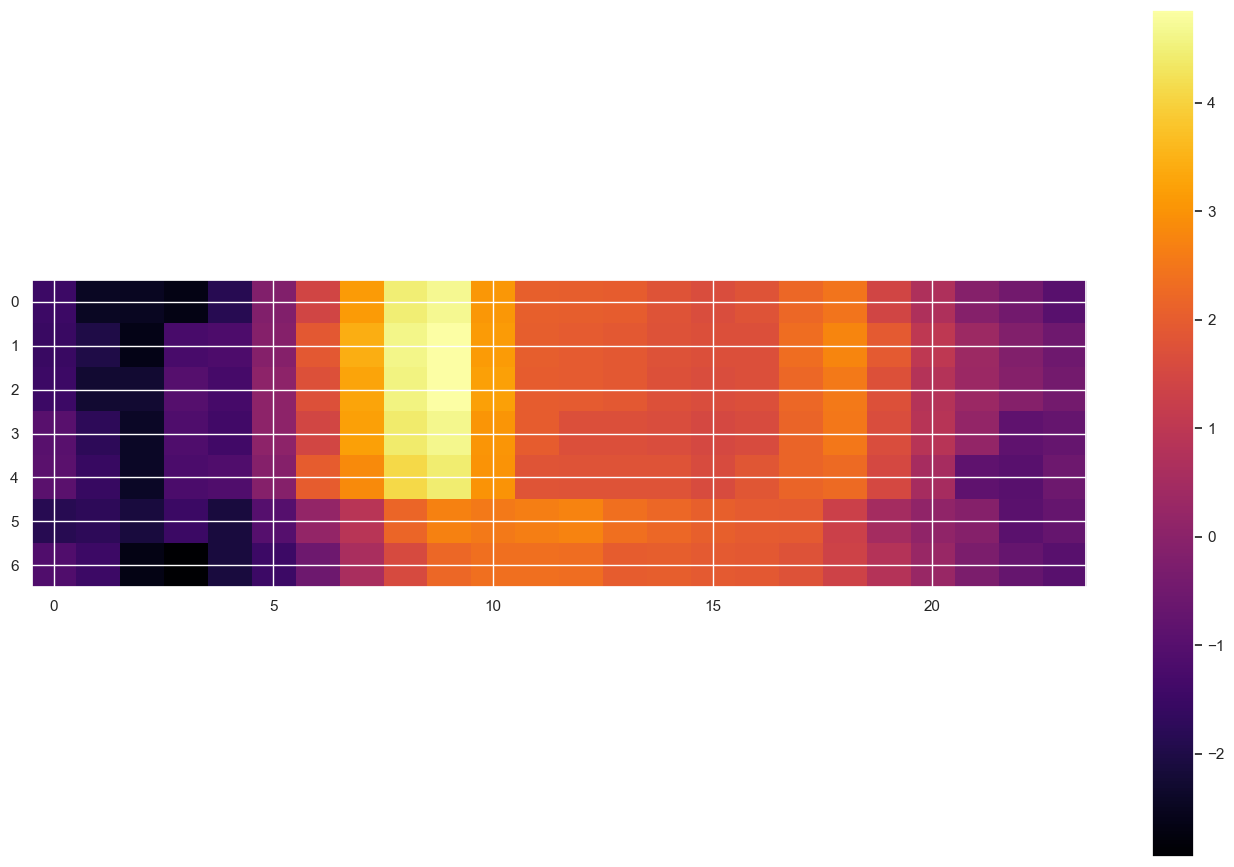

In [24]:
m = plt.imshow(np.array(az.extract(trace.posterior)["alpha"]).mean(axis=1).reshape((7, 24)), cmap="inferno", interpolation=None)
plt.colorbar(m)

In [25]:
post_preds = np.array(az.extract(trace.posterior_predictive)["c"])
post_preds.shape

(8759, 40000)

In [26]:
filtered_data.filter((pl.col("month") == 5) & (pl.col("day") == 9))

site_id,site_name,record_time,count_incoming,count_outgoing,year,month,day,hour,weekday,temp_max_c,temp_min_c,temp_avg_c,rel_humidity_perc,dir_deg,speed_ms,dir_std,speed_std,period,temp_z,humidity_z,windspeed_z
i64,str,"datetime[μs, UTC]",i64,i64,i32,u32,u32,u32,u32,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64
100041854,"""Thorndon Quay""",2022-05-09 00:00:00 UTC,0,2,2022,5,9,0,0,18.0,17.8,17.8,79,354,7.9,15.0,2.1,1.0,0.815689,0.280849,0.465639
100041854,"""Thorndon Quay""",2022-05-09 01:00:00 UTC,0,0,2022,5,9,1,0,18.0,17.8,17.9,79,350,9.3,15.0,2.3,1.0,0.841863,0.280849,0.862227
100041854,"""Thorndon Quay""",2022-05-09 02:00:00 UTC,0,0,2022,5,9,2,0,18.0,17.9,18.0,78,351,8.8,14.0,2.4,1.0,0.868038,0.197582,0.720589
100041854,"""Thorndon Quay""",2022-05-09 03:00:00 UTC,0,0,2022,5,9,3,0,18.0,17.7,17.9,79,350,8.5,14.0,2.1,1.0,0.841863,0.280849,0.635605
100041854,"""Thorndon Quay""",2022-05-09 04:00:00 UTC,0,0,2022,5,9,4,0,18.0,17.9,17.9,80,351,8.5,18.0,2.5,1.0,0.841863,0.364116,0.635605
100041854,"""Thorndon Quay""",2022-05-09 05:00:00 UTC,0,1,2022,5,9,5,0,18.2,17.9,18.1,79,356,9.4,15.0,2.5,1.0,0.894213,0.280849,0.890555
100041854,"""Thorndon Quay""",2022-05-09 06:00:00 UTC,0,3,2022,5,9,6,0,18.3,18.2,18.2,79,354,10.0,16.0,2.5,1.0,0.920388,0.280849,1.060521
100041854,"""Thorndon Quay""",2022-05-09 07:00:00 UTC,1,22,2022,5,9,7,0,18.3,18.2,18.2,78,349,9.1,18.0,2.5,1.0,0.920388,0.197582,0.805572
100041854,"""Thorndon Quay""",2022-05-09 08:00:00 UTC,4,90,2022,5,9,8,0,18.3,17.8,18.1,81,355,10.0,14.0,2.4,1.0,0.894213,0.447383,1.060521


In [27]:
post_preds[47:71,0]

array([ 0,  0,  0,  0,  0,  1,  7, 13, 64, 85, 25,  4,  3,  4, 11,  3,  4,
        0,  4,  4,  1,  0,  0,  2])

In [28]:
day_post_preds = np.array([post_preds[23 + 72 + 72:][i*24:(i+1)*24] for i in range(7)])
post_means = day_post_preds.mean(axis=2)
post_stds = day_post_preds.std(axis=2)

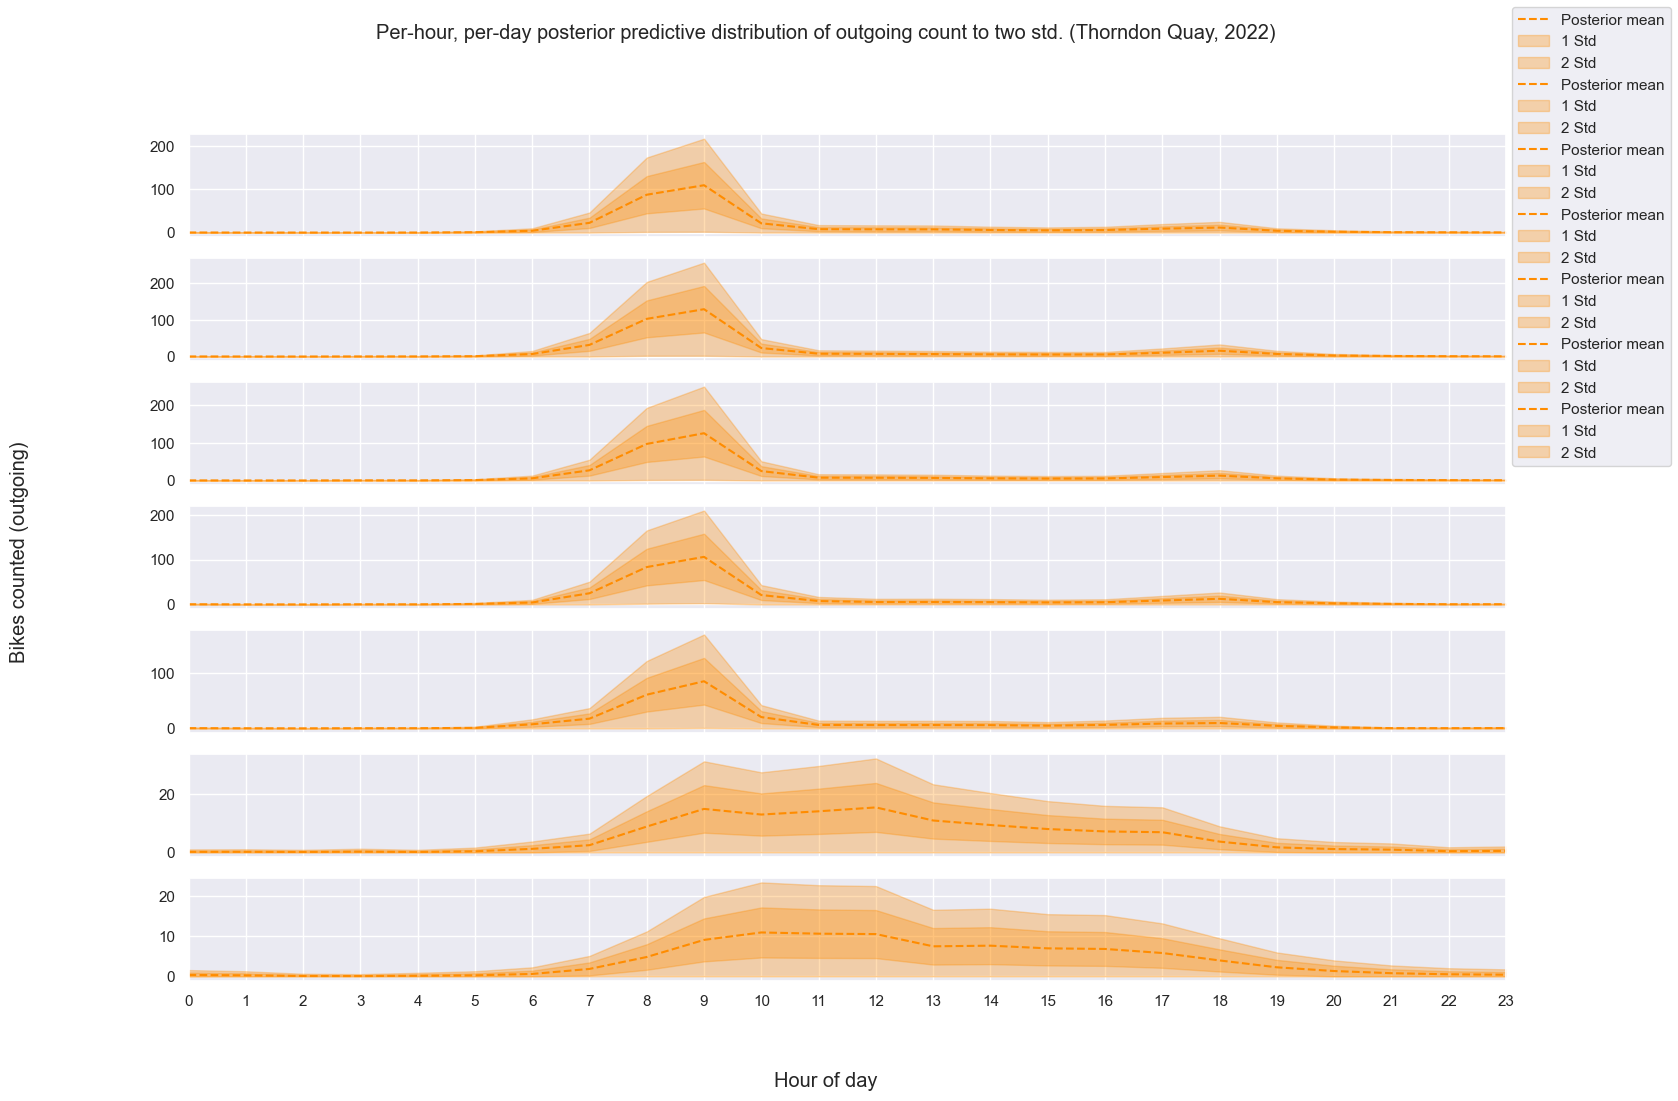

In [29]:
hours = np.arange(24)

# obs_mean = observed_stats.select("count_mean").to_numpy().flatten()

# post_mean = post_preds[:24].mean(axis=1)
# post_std = post_preds[:24].std(axis=1)

# plt.plot(hours, obs_mean, label="Observation mean", color="blue")
fig, axs = plt.subplots(nrows=7, sharex=True)
for i, (mean, std) in enumerate(zip(post_means, post_stds)):
    ax = axs[(i+5) % 7]
    ax.plot(hours, mean, label="Posterior mean", color="darkorange", linestyle="--")
    ax.fill_between(hours, (mean - std).clip(min=0), (mean + std), alpha=0.3, label="1 Std", color="darkorange")
    ax.fill_between(hours, (mean - 2*std).clip(min=0), (mean + 2*std), alpha=0.3, label="2 Std", color="darkorange")

plt.xticks(hours)
plt.xlim(0,23)

# fig.supxlabel
fig.supxlabel("Hour of day")
fig.supylabel("Bikes counted (outgoing)")
fig.legend(loc="upper right")
plt.suptitle("Per-hour, per-day posterior predictive distribution of outgoing count to two std. (Thorndon Quay, 2022)")
plt.show()

In [77]:
df_preds = filtered_data.with_columns(
    pl.Series(name="predictions", values=trace.posterior_predictive["c"][0,0,:].to_numpy())
).filter(
    (pl.col("weekday") < 5) &
    (pl.col("hour") >= 8) &
    (pl.col("hour") <= 9)
).pivot(index=["year", "month", "day"], columns="hour", values=["predictions", "count_outgoing"])

In [1]:
df_preds

NameError: name 'df_preds' is not defined

(0.0, 450.0)

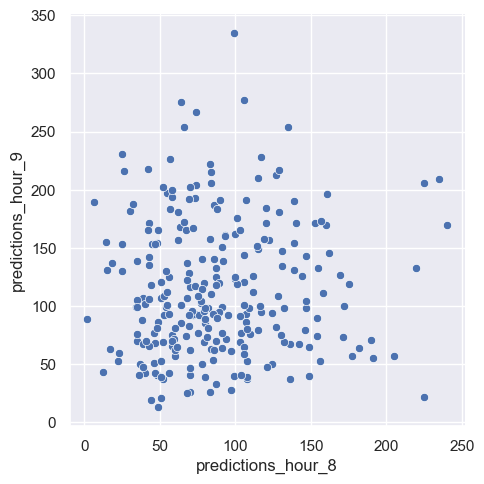

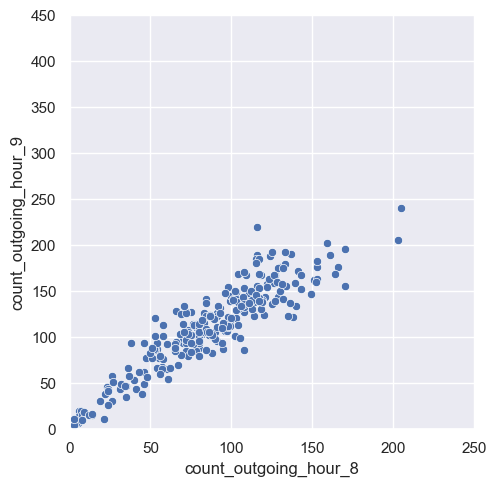

In [82]:
sns.relplot(df_preds, x="predictions_hour_8", y="predictions_hour_9")
sns.relplot(df_preds, x="count_outgoing_hour_8", y="count_outgoing_hour_9")
plt.xlim(0,250)
plt.ylim(0,450)

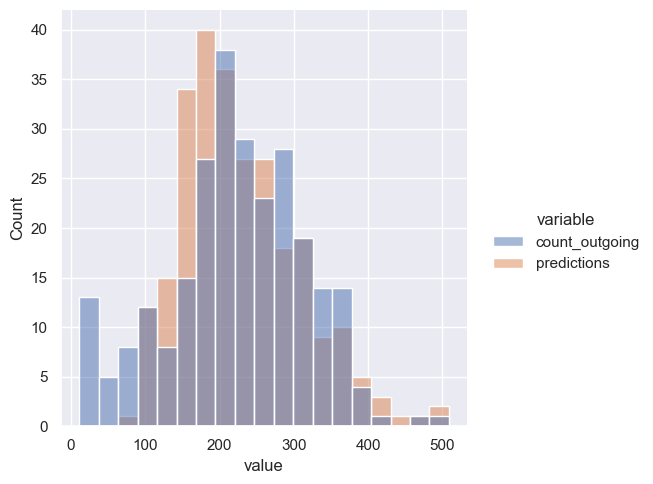

In [64]:
sns.displot(
    (
        df_preds.filter(
            (pl.col("weekday") < 5) &
            (pl.col("hour") > 6) &
            (pl.col("hour") < 10)
        ).set_sorted(
            pl.col("record_time")
        ).group_by_dynamic(
            pl.col("record_time"), 
            every="1d"
        ).agg(
            pl.col("count_outgoing").sum(), 
            pl.col("predictions").sum()
        ).melt(
            id_vars="record_time",
            value_vars=["count_outgoing", "predictions"]
        )
    ),
    x="value",
    hue="variable",
)

In [ ]:
sns.relplot(df_preds, x=")